<a href="https://colab.research.google.com/github/lucassribs/analise_sentimentos_em_filmes/blob/main/Projeto_Aplicado_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importação das Bibliotecas:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import spacy
import nltk
import string

In [ ]:
# Baixe a lista de stopwords e o modelo de tokenização:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
# Carrega o modelo pré-treinado "en_core_web_sm" do spaCy para processamento de texto em inglês:
nlp = spacy.load('en_core_web_sm')

O dataset utilizado para o projeto para fazer o Treinamento do Modelo foi extraído do repositório Github do usuário Shreyas Wankhedeem.
Os dados são públicos e não sensíveis. Podem ser
acessados utilizando o link:
https://github.com/shreyaswankhede/IMDb-Web-Scraping-and-Sentiment-Analysis

O Dataset "imdbmovies.csv" apresenta as seguintes características:

Metadados:
- Formato do arquivo: CSV;
- Número de linhas: 3883;
- Número de colunas: 10.

Features:
- IMDBID	: ID do filme;
- Title	: título do filme;
- Genre: Gênero do filme;
- Year: Ano de lançamento;
- URL:  URL associada ao filme no IMDb;
- Audience_Rating: A classificação dada pelo público ao filme;
- Critic_Rating: A classificação dada pela crítica especializada ao filme;
- Budget_In_Millions: O orçamento do filme em milhões de dólares;
- User_Review: OS comentários em inglês escritos por usuários do IMDb sobre o filme.
- Polarity: A polaridade associada às revisões dos usuários.

# Análise Exploratória:

In [ ]:
# Importar a base de dados para a estrututra de DataFrame do Pandas:
df = pd.read_csv("/content/imdbmovies.csv", sep=";")

In [ ]:
# Utilizando o método head() do Pandas para retornar as 5 primeiras linhas do Dataframe:
df.head()

,IMDBID,Title,Genre,Year,URL,Audience_Rating,Critic_Rating,Budget_In_Millions,User_Review,Polarity
0,tt0035423,Kate & Leopold,"Comedy, Fantasy, Romance",2001,https://m.media-amazon.com/images/M/MV5BNmNlN2...,6.4,4.4,48.0,"Funny lines, bad plot, one hot actor",Negative
1,tt0091288,Jean de Florette,Drama,1987,https://m.media-amazon.com/images/M/MV5BMTgxND...,8.1,0.0,0.0,Escape to a rural idyll from another age,Positive
2,tt0108148,Iron Monkey,"Action, Crime, Drama",2001,https://m.media-amazon.com/images/M/MV5BYjJmMG...,7.6,7.9,11.0,"Very enjoyable, well done action fest with a f...",Positive
3,tt0118589,Glitter,"Drama, Music, Romance",2001,https://m.media-amazon.com/images/M/MV5BMGJkN2...,2.2,1.4,22.0,Oh the pain.... Mariah believes she is Streisa...,Negative
4,tt0118926,The Dancer Upstairs,"Crime, Drama, Thriller",2003,https://m.media-amazon.com/images/M/MV5BODE2OD...,7.0,6.4,0.0,A very interesting movie with a semi-political...,Positive


In [ ]:
# Número de instâncias e atributos:
df.shape

(3883, 10)

In [ ]:
# Remoção de colunas:
df = df.drop(['IMDBID', 'URL', 'Audience_Rating', 'Critic_Rating', 'Budget_In_Millions'], axis=1)

In [ ]:
df.head()

,Title,Genre,Year,User_Review,Polarity
0,Kate & Leopold,"Comedy, Fantasy, Romance",2001,"Funny lines, bad plot, one hot actor",Negative
1,Jean de Florette,Drama,1987,Escape to a rural idyll from another age,Positive
2,Iron Monkey,"Action, Crime, Drama",2001,"Very enjoyable, well done action fest with a f...",Positive
3,Glitter,"Drama, Music, Romance",2001,Oh the pain.... Mariah believes she is Streisa...,Negative
4,The Dancer Upstairs,"Crime, Drama, Thriller",2003,A very interesting movie with a semi-political...,Positive


In [ ]:
# verificar a quantidade de valores nulos em cada coluna de um DataFrame:
df.isnull().sum()

Title           0
Genre           4
Year            0
User_Review    67
Polarity        1
dtype: int64

In [ ]:
# remover todas as linhas que contêm valores nulos (NaN)
df = df.dropna()

In [ ]:
# Verificar a remoção de valores nulos:
df.isnull().sum()

Title          0
Genre          0
Year           0
User_Review    0
Polarity       0
dtype: int64

In [ ]:
# Verificar formato após a remoção de colunas desnecessárias e valores nulos:
df.shape

(3815, 5)

In [ ]:
# Renomear coluna do Rótulo:
df.rename(columns={'Polarity': 'Label'}, inplace = True)

In [ ]:
# Converter as categorias textuais (rótulos) em valores numéricos:
df['Label'] = df['Label'].map({'Positive': 1, 'Negative': 0})

In [ ]:
df.head()

,Title,Genre,Year,User_Review,Label
0,Kate & Leopold,"Comedy, Fantasy, Romance",2001,"Funny lines, bad plot, one hot actor",0
1,Jean de Florette,Drama,1987,Escape to a rural idyll from another age,1
2,Iron Monkey,"Action, Crime, Drama",2001,"Very enjoyable, well done action fest with a f...",1
3,Glitter,"Drama, Music, Romance",2001,Oh the pain.... Mariah believes she is Streisa...,0
4,The Dancer Upstairs,"Crime, Drama, Thriller",2003,A very interesting movie with a semi-political...,1


In [ ]:
# Verificando a proporção dos rótulos existentes:
df.Label.value_counts()

1    1949
0    1866
Name: Label, dtype: int64

In [ ]:
# O Dataset é balanceado

In [ ]:
#  Obter os valores únicos presentes na coluna 'Year' do DataFrame:
df.Year.unique()

array([2001, 1987, 2003, 2000, 2005, 2002, 2004, 2008, 2007, 2006, 2012,
       2009, 2013, 2014, 2015, 2016, 2010, 2017, 2018, 2011, 2019])

In [ ]:
# Exiba a quantidade de filmes únicos:
quantidade_filmes_unicos = df['Title'].nunique()
print("Quantidade de filmes únicos:", quantidade_filmes_unicos)

Quantidade de filmes únicos: 3815


In [ ]:
# Imprimir um Review positivo de usuário:
print(df.User_Review[21])

One of the most surprisingly well done films I have seen in quite some time.


In [ ]:
# Imprimir um Review negativo de usuário:
print(df.User_Review[35])

bad film suicidal title


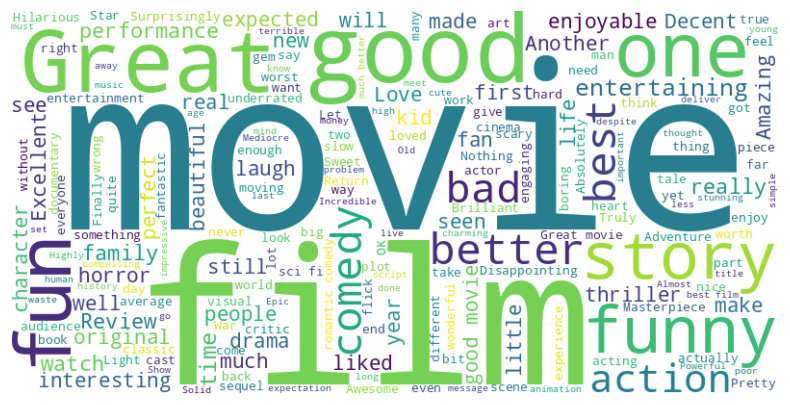

In [ ]:
# Word CLoud é uma representação visual de dados de texto por meio de um gráfico onde o
# palavras mais frequentes (ou mais importantes) têm tamanhos maiores.
# Vamos construir uma nuvem de palavras para ter uma ideia das palavras mais importantes.

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crie uma string contendo todos os textos dos comentários concatenados
all_words = " ".join(review for review in df["User_Review"])

# Crie uma instância de WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plote a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


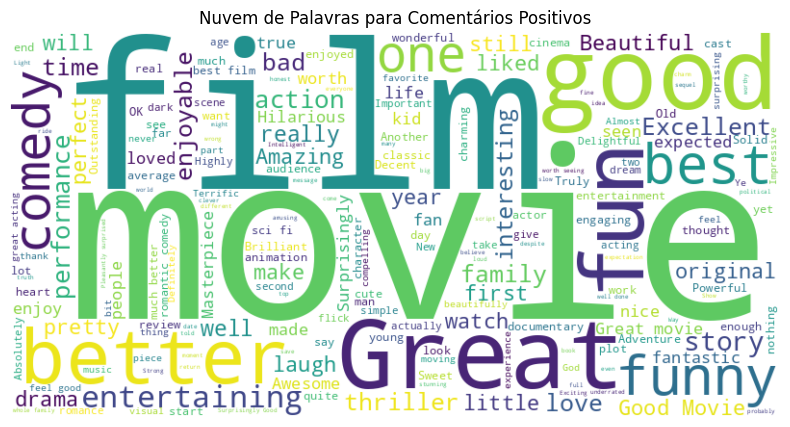

In [ ]:
# Filtrar os comentários positivos (Label == 1)
positive_reviews = df[df['Label'] == 1]

# Criar Word Cloud para comentários positivos
positive_text = " ".join(review for review in positive_reviews["User_Review"])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Plotar a Word Cloud para comentários positivos
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()


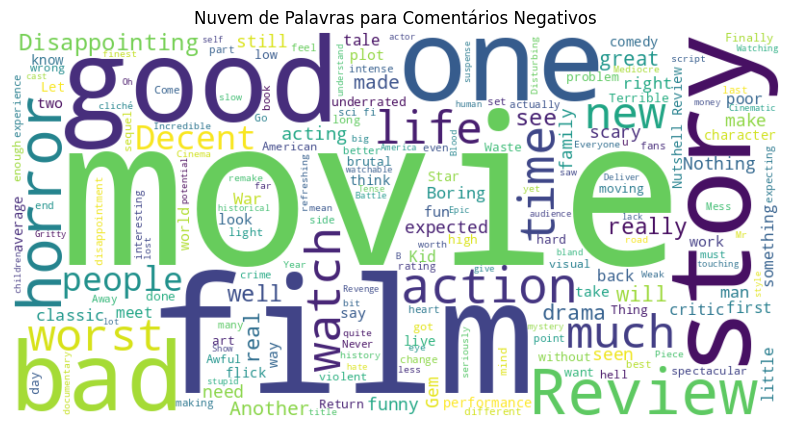

In [ ]:
# Filtrar os comentários negativos (Label == 0)
negative_reviews = df[df['Label'] == 0]

# Criar uma Word Cloud para comentários negativos
negative_text = " ".join(review for review in negative_reviews["User_Review"])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plotar uma Word Cloud para comentários negativos
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud para Comentários Negativos')
plt.axis("off")
plt.show()

## Pré-processamento:





In [ ]:
# Função para Pré-processamento de texto:
def preprocess_text(text):
    text = text.lower()  # Converte para minúsculas
    text = re.sub(r'\W', ' ', text)  # Remove caracteres não alfanuméricos
    text = re.sub(r'\s+', ' ', text)  # Remove espaços extras

    # Tokenização usando bilioteca NLTK
    tokens = word_tokenize(text)

    # Remova stopwords usando NLTK
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização usando biblioteca spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]

    # Remova pontuações
    tokens = [word for word in tokens if word not in string.punctuation]

    return " ".join(tokens)

In [ ]:
# Aplicar Pré-processamento de texto na coluna User_Review:
df['User_Review'] = df['User_Review'].apply(preprocess_text)

## Divisão do conjunto de dados em conjuntos de treinamento e teste:

In [ ]:
# Divisão dos dados
X = df['User_Review']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

## Feature Extraction (Extração de características):
Transformar dados de texto em características numéricas para serem usadas no modelo de machine learning.
TF-IDF (Term Frequency-Inverse Document Frequency): técnica para dar mais peso às palavras mais importantes.

In [ ]:
# Vetorização de texto usando TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Treinamento do modelo de Regressão Logística:
Treinar um modelo de regressão logística usando a biblioteca Scikit-Learn.
Usar os dados de treinamento para ajustar o modelo aos sentimentos conhecidos dos reviews.

In [ ]:
# Treinamento do modelo de regressão logística
model = LogisticRegression(max_iter=10000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
# Previsões
y_pred = model.predict(X_test_tfidf)
print( y_pred[0:10])

[1 0 0 0 1 1 0 0 0 1]


## Avaliação do Modelo:

In [ ]:
# Avaliação do modelo - Acurácia, Matriz de Confusão e Classification Report
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{confusion}')
print(f'Relatório de Classificação:\n{report}')

Acurácia: 0.7982532751091703
Matriz de Confusão:
[[464  96]
 [135 450]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       560
           1       0.82      0.77      0.80       585

    accuracy                           0.80      1145
   macro avg       0.80      0.80      0.80      1145
weighted avg       0.80      0.80      0.80      1145



Os Resultados esperados são dessas medidas de avaliação

## Produto Final:

In [ ]:
# Abrir o outro Dataframe com 10 filmes e selecionar alguns filmes para fazer o Pré-Processamento dos textos dos Reviews e
# o Modelo classificar e usar a análise de sentimentos como apoio na tomada de decisão para a plataforma de streaming Mackflix
# analisar as preferências de gênero e temas de filmes pelo público :

In [ ]:
df_filmes = pd.read_csv("/content/IMDB_Reviews_for_sentiment_analysis.csv")

In [ ]:
df_filmes.head()

,Movie Title,Movie Rating,Movie Poster,Review Title,Review Text,Rating By User,Review Date,Review Author
0,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,One Step Above Masterpiece!,"It's honestly absurd how good the ""Spider-Vers...",10.0,2023-05-31,MiroslavKyuranov
1,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,Masterful IMAX Spider-Man,"The animation, flow of everything, genius char...",10.0,2023-06-02,UniqueParticle
2,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,One of the best sequels to anything ever made,If it wasn't already obvious in the first film...,10.0,2023-06-02,pugpool10
3,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,A new Empire Strikes Back,This film is a visual concert. The animation a...,10.0,2023-06-02,rickothan
4,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,My movie of 2023 so far.,It's been some time since I've walked out from...,10.0,2023-06-11,Sleepin_Dragon


In [ ]:
#Verificar os filmes disponíveis no DataFrame:
df_filmes['Movie Title'].unique()

array(['1.Spider-Man: Across the Spider-Verse(2023)',
       '2.Guardians of the Galaxy Vol. 3(2023)',
       '3.John Wick: Chapter 4(2023)',
       "4.Guy Ritchie's The Covenant(2023)", '5.Air(I) (2023)',
       '6.A Man Called Otto(2022)', '7.Tetris(2023)',
       '8.Dungeons & Dragons: Honor Among Thieves(2023)',
       '9.The Flash(2023)', '10.Missing(2023)'], dtype=object)

In [ ]:
# Verificar se há valores nulos que interfiram na classificação:
df_filmes.isnull().sum()

Movie Title        0
Movie Rating       0
Movie Poster       0
Review Title       0
Review Text        0
Rating By User    45
Review Date        0
Review Author      0
dtype: int64

In [ ]:
#Somente a coluna "Rating By User" tem valores nulos porém não precisaremos dessa coluna

In [ ]:
df_filmes.rename(columns={'Review Text': 'User_Review'}, inplace = True)

## Selecionando o filme Spider-Man: Across the Spider-Verse(2023) e classificando os comentários:

In [ ]:
Spider_Man = pd.DataFrame(df_filmes[df_filmes['Movie Title'] == "1.Spider-Man: Across the Spider-Verse(2023)"])

In [ ]:
Spider_Man.head()

,Movie Title,Movie Rating,Movie Poster,Review Title,User_Review,Rating By User,Review Date,Review Author
0,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,One Step Above Masterpiece!,"It's honestly absurd how good the ""Spider-Vers...",10.0,2023-05-31,MiroslavKyuranov
1,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,Masterful IMAX Spider-Man,"The animation, flow of everything, genius char...",10.0,2023-06-02,UniqueParticle
2,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,One of the best sequels to anything ever made,If it wasn't already obvious in the first film...,10.0,2023-06-02,pugpool10
3,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,A new Empire Strikes Back,This film is a visual concert. The animation a...,10.0,2023-06-02,rickothan
4,1.Spider-Man: Across the Spider-Verse(2023),8.9,https://m.media-amazon.com/images/M/MV5BMzI0Nm...,My movie of 2023 so far.,It's been some time since I've walked out from...,10.0,2023-06-11,Sleepin_Dragon


In [ ]:
Spider_Man.shape

(510, 8)

In [ ]:
# Aplicar Pré-processamento de texto na coluna User_Review de Spider_Man:
Spider_Man['User_Review'] = Spider_Man['User_Review'].apply(preprocess_text)

In [ ]:
X = Spider_Man['User_Review']

In [ ]:
Spider_Man_tfidf = vectorizer.transform(X)

In [ ]:
# Previsões
Class_Spider_Man = model.predict(Spider_Man_tfidf)

In [ ]:
# Contagem dos valores da previsão
count_positive = (Class_Spider_Man == 1).sum()
count_negative = (Class_Spider_Man == 0).sum()

print("Número de avaliações positivas:", count_positive)
print("Número de avaliações negativas:", count_negative)

Número de avaliações positivas: 492
Número de avaliações negativas: 18


In [ ]:
# O filme tem 492 avaliações positivas e somente 10 negativas e pode ser futuramente adicionado para o catálogo da Mackflix

## Selecionando o filme Tetris(2023) e classificando os comentários:

In [ ]:
Tetris = pd.DataFrame(df_filmes[df_filmes['Movie Title'] == "7.Tetris(2023)"])


In [ ]:
Tetris.head()

In [ ]:
Tetris.shape

(157, 8)

In [ ]:
Tetris['User_Review'] = Tetris['User_Review'].apply(preprocess_text)

In [ ]:
X = Tetris['User_Review']

In [ ]:
Tetris_tfidf = vectorizer.transform(X)

In [ ]:
# Previsões
Class_Tetris = model.predict(Tetris_tfidf)

In [ ]:
# Contagem dos valores da previsão
count_positive = (Class_Tetris == 1).sum()
count_negative = (Class_Tetris == 0).sum()

print("Número de avaliações positivas:", count_positive)
print("Número de avaliações negativas:", count_negative)

Número de avaliações positivas: 145
Número de avaliações negativas: 12


In [ ]:
# O filme tem 145 avaliações positivas e somente 12 negativas e pode ser futuramente adicionado para o catálogo da Mackflix